# Part 1 Sequence Tagging: NER


## Q1.1 Word Embedding

### Q1.1.1 Download Dependency

In [1]:
!pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


### Q1.1.2 Download the pretrained word2vec embeddings 

In [1]:
import gensim.downloader
import numpy as np
import pandas as pd
import csv
import random
import tqdm
import time
import spacy
from sklearn.metrics.pairwise import cosine_similarity
from seqeval.metrics import f1_score

#Download the embeddings "word2vec-google-news-300"
w2v = gensim.downloader.load('word2vec-google-news-300')

---
### Question 1.1
###### Based on word2vec embeddings you have downloaded, use cosine similarity to find the most similar word to each of these words: (a) “student”; (b) “Apple”; (c) “apple”. Report the most similar word and its cosine similarity.

In [3]:
def get_word_and_cosine_similarity(word:list, top_n:int):
    result = {}
    for w in word:
        similarities = w2v.cosine_similarities(w2v[w], w2v.vectors)
        sorted_similarities = sorted(similarities[:], reverse=True)[:top_n+1]
        result[w] = [(w2v.index_to_key[np.where(similarities == s)[0][0]], s) for s in sorted_similarities if w2v.index_to_key[np.where(similarities == s)[0][0]]!=w]
    return result

In [4]:
word_list = ["student", "Apple", "apple"]
print("Most similar word and its cosine similarity by using .most_similar(): ")
for word in word_list:
    print(word+'\t', w2v.most_similar(word,topn=1))

print("\nMost similar word and its cosine similarity by using .cosine_similarities(): ")
r = get_word_and_cosine_similarity(word_list, 1)
for k,v in r.items():
    print(k+'\t', v)

Most similar word and its cosine similarity by using .most_similar(): 
student	 [('students', 0.7294867038726807)]
Apple	 [('Apple_AAPL', 0.7456986308097839)]
apple	 [('apples', 0.720359742641449)]

Most similar word and its cosine similarity by using .cosine_similarities(): 
student	 [('students', 0.7294867)]
Apple	 [('Apple_AAPL', 0.74569863)]
apple	 [('apples', 0.72035974)]


---
### 1.2 Data
###### Then you can start to prepare the dataset. For NER, you will work with [CoNLL2003](https://github.com/TheAnig/NER-LSTM-CNN-Pytorch/tree/master/data) (click and download “eng.testa”, “eng.testb”, “eng.train”). Before training, you need to preprocess the dataset such that each of them contains a training file, a development file and a test file. The development file is used to select the best model during training. The test file is used for final evaluation. For CoNLL2003, the training, development and test file corresponds to “eng.train”, “eng.testa” and “eng.testb”, respectively. Note that you only need to use the first and the last column of each line corresponding to the input word and the word label, respectively. A screenshot of the data is shown in Figure 1. In this example, there are two sentences (separated by ‘\n’). The input for each sentence is composed of the words from the first column. For example, the first sentence in Figure 1 corresponds to “CRICKET - LEICESTERSHIRE TAKE OVER AT TOP AFTER INNINGS VICTORY.” The label for each of the first 3 words CRICKET, -, LERCESTERSHIRE corresponds to ‘O’, ‘O’, ‘I-ORG’, respectively

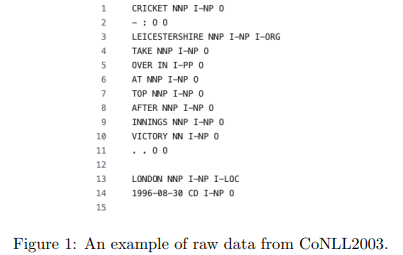

In [51]:
# Define the file paths
train_file = "data/eng.train"
verification_file = "data/eng.testa"
test_file = "data/eng.testb"

# Function to read and process a CoNLL2003 file and returns df
def process_files(file_path, csv_name):
    """ Parameters:
        - file_path: CoNLL2003 files
        - csv_name: Bool
             returns pd file, columns: ["Sentence Number", "Word", "NEr tag"]
    """
    data = []
    sentence_no = 1
    with open(file_path, 'r', encoding='utf-8') as file:
        for row in file:
            line = row.strip()
            if not line:  # Empty line indicates end of a sentence
                sentence_no += 1
            else:
                ner = line.split(" ")
                # ensuring that for each data there is a word and the word's NER label
                assert all([ner[i] for i in range(4)])
                data.append([sentence_no, ner[0], ner[3]])
    
    with open(csv_name, 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["Sentence Number", "Word", "NEr tag"])
        for word in data:
            writer.writerow([word[0], word[1], word[2]])
    return pd.read_csv(csv_name)

# Function to load existing csv file if have
def load_files(file_name):
    return pd.read_csv(file_name)

# Process the data files
train_df = process_files(train_file, csv_name="data/train_data.csv")
validation_df = process_files(verification_file, csv_name="data/verification_data.csv")
test_df = process_files(test_file, csv_name="data/test_data.csv")

### Question 1.2
###### (a) Describe the size (number of sentences) of the training, development and test file for CoNLL2003. Specify the complete set of all possible word labels based on the tagging scheme (IO, BIO, etc.) you chose.

In [52]:
file_labels = ["Training", "Verification", "Test"]
for i, df in enumerate([train_df, validation_df, test_df]):
    print("="*100)
    print(f"{file_labels[i]} data information")
    print(f"> Number of sentences:    {df['Sentence Number'].max()}")
    print(f"> Count of Unique words:  {len(df['Word'].unique())}")
    print(f"> Type of tags:           {sorted(df['NEr tag'].unique())}\n")
print("="*100,'\n')

print("With the given shapes, parameters and type of tags exists, we select the tagging scheme to be BIO as it has B,I,O tags.")

Training data information
> Number of sentences:    14987
> Count of Unique words:  23623
> Type of tags:           ['B-LOC', 'B-MISC', 'B-ORG', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']

Verification data information
> Number of sentences:    3466
> Count of Unique words:  9966
> Type of tags:           ['B-MISC', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']

Test data information
> Number of sentences:    3684
> Count of Unique words:  9489
> Type of tags:           ['B-LOC', 'B-MISC', 'B-ORG', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']


With the given shapes, parameters and type of tags exists, we select the tagging scheme to be BIO as it has B,I,O tags.


###### (b) Choose an example sentence from the training set of CoNLL2003 that has at least two named entities with more than one word. Explain how to form complete named entities from the label for each word, and list all the named entities in this sentence.

In [54]:
def q1b(df):
    while True:
        # Keeps track of number of entities
        count =0
        
        # Generate a random sentence number
        rand = random.randint(1,df['Sentence Number'].iloc[-1]+1)

        # Filter df by sentence_number
        mask = df['Sentence Number'] == rand
        rand_df = df[mask].reset_index()

        # Check is to ensure we do not double count consecutive word with same tag
        check = None

        # Check through dataframe and count number of entities
        for x in range(len(rand_df['NEr tag'])):
            if x < len(rand_df['NEr tag'])-1:
                # Check tag !='O', next tag is same as current tag 
                if rand_df['NEr tag'].iloc[x]!='O' and rand_df['NEr tag'].iloc[x+1] == rand_df['NEr tag'].iloc[x]:

                    # updating check if tags are the same 
                    if check == rand_df['NEr tag'].iloc[x-1]:
                        check = rand_df['NEr tag'].iloc[x]

                    # Incrementing count and updating check
                    else:
                        count+=1
                        check = rand_df['NEr tag'].iloc[x]

                # Reinitialise check to None once 'O' detected to ensure other different named entities of same tag as previous is counted.
                elif rand_df['NEr tag'].iloc[x]=='O':
                    check = None

                # Return once count >=2
                if count >=2:
                    return rand_df          

def process(df):
    sentence = ''
    tag = ''
    sen_and_tag = ''
    for x in range (len(df['Word'])):
        sentence += str(df['Word'].iloc[x])
        sentence+= ' '
        tag += str(df['NEr tag'].iloc[x])
        tag+=' '
        sen_and_tag +=str(df['Word'].iloc[x])
        sen_and_tag +='/'
        sen_and_tag += str(df['NEr tag'].iloc[x])
        sen_and_tag += ' '
    print(f"sentence: {sentence}\n")
    print(f"tag: {tag}\n")
    print(f"sentence with tag: {sen_and_tag}\n")

q1b_df = q1b(train_df)
process(q1b_df)

sentence: Of the 14 remaining suits , 10 were filed by employees of industrial Brush Wellman customers and Brush Wellman liability in such suits is typically covered by insurance , Timothy Reid , vice president of corporate communications , said on the call . 

tag: O O O O O O O O O O O O O I-ORG I-ORG O O I-ORG I-ORG O O O O O O O O O O I-PER I-PER O O O O O O O O O O O O 

sentence with tag: Of/O the/O 14/O remaining/O suits/O ,/O 10/O were/O filed/O by/O employees/O of/O industrial/O Brush/I-ORG Wellman/I-ORG customers/O and/O Brush/I-ORG Wellman/I-ORG liability/O in/O such/O suits/O is/O typically/O covered/O by/O insurance/O ,/O Timothy/I-PER Reid/I-PER ,/O vice/O president/O of/O corporate/O communications/O ,/O said/O on/O the/O call/O ./O 



In [57]:
def list_named_entities(df):
    entity =''
    l =[]
    t = []
    for x in range(len(df['Word'])):
        if df['NEr tag'].iloc[x]!='O':
            entity+=str(df['Word'].iloc[x])
            entity+=' '
        else:
            if (entity!=''):
                l.append(entity)
                t.append(str(df['NEr tag'].iloc[x-1]))
                entity = ''
    d = {k: v for k, v in zip(l,t)} 
    return l,d

l,d= list_named_entities(q1b_df)
print(f"list of name entities: {l}")
print(f"list of name entities with tags {d}")

print('\nTo form complete named entities from the label for each word, we need to consider firstly that the tags are provided/able to be retrieved by corpus/gazetteer. For each single/consequtive Name Entities(ER) recognition tags, it is the complete phrase of the name entity. The type of the entity can be known by the tag itself, if in this example, ORG was tagged and hence we know the word/phrase is an Organization. However, the data provided does not fully follow the BIO tagging scheme entirely, with the start of the NE phrase not tagged with a "B", and since when we are using the "BIO" tagging scheme there is no Stop/Ending tags, hence the only way we can segregate phrases is by using the "O"-outside "BIO" tag. ')

list of name entities: ['Brush Wellman ', 'Brush Wellman ', 'Timothy Reid ']
list of name entities with tags {'Brush Wellman ': 'I-ORG', 'Timothy Reid ': 'I-PER'}

To form complete named entities from the label for each word, we need to consider firstly that the tags are provided/able to be retrieved by corpus/gazetteer. For each single/consequtive Name Entities(ER) recognition tags, it is the complete phrase of the name entity. The type of the entity can be known by the tag itself, if in this example, ORG was tagged and hence we know the word/phrase is an Organization. However, the data provided does not fully follow the BIO tagging scheme entirely, with the start of the NE phrase not tagged with a "B", and since when we are using the "BIO" tagging scheme there is no Stop/Ending tags, hence the only way we can segregate phrases is by using the "O"-outside "BIO" tag. 


---
### 1.3 Model
###### Now with the pretrained word embeddings acquired from Section 1.1, and the CoNLL2003 dataset acquired from Section 1.2, you need to train an NER model using the training set, conforming to these requirements:
• Use the pretrained word embeddings from Section 1.1 as inputs; do not update them during training (they are “frozen”).

• Design a neural network transforming the input for each word to its final vector representation, which will be fed into the softmax classifier to predict the final label for each word. The neural network could be a simple linear layer, a feedforward network (a linear transformation plus a nonlinear activation function), or a recurrent neural network (RNN/LSTM). You are encouraged to use more effective networks (e.g., LSTM) because the performance of the model will be taken into consideration when graded.

• Use the development set to evaluate the performance of the model for each epoch during training. Please use f1 score to measure the performance. For evaluation metric and code, refer to the following link: https://github.com/chakki-works/seqeval/tree/master. (Please make sure your sequence tagging scheme aligns with the provided evaluation code. Otherwise,
you may revise the code accordingly.)

• Use the mini-batch strategy during training. You may choose any preferred optimizer (e.g., SGD, Adagrad, Adam, RMSprop). Be careful when you choose your initial learning rate and mini-batch size. (You may use the development set to check the performance and decide the optimal configuration.) Train the network until the f1 score on the development set is not increasing. Use the trained network to classify words in the test set.

#### Question 1.3
###### (a) Discuss how you deal with new words in the training set which are not found in the pretrained dictionary. Likewise, how do you deal with new words in the test set which are not found in either the pretrained dictionary or the training set? Show the corresponding code snippet.

Max sentences for train_df=113,
      validation_df=109, test_df=124


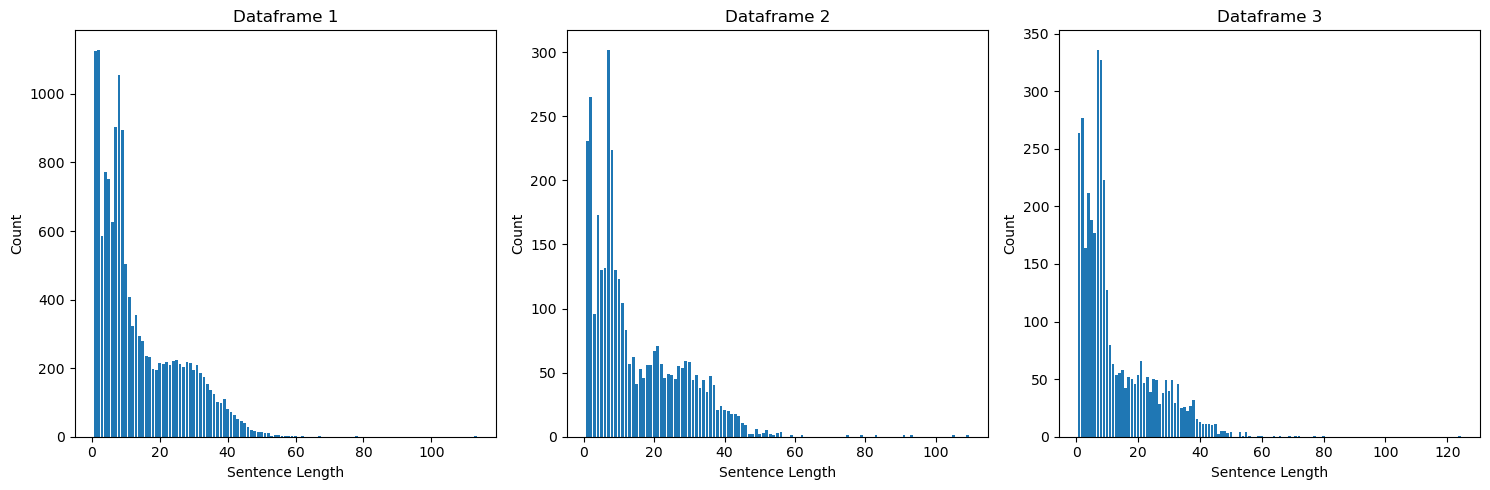

In [58]:
from collections import defaultdict
import matplotlib.pyplot as plt

def sentence_integrate(data):
    agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                 s["NEr tag"].values.tolist())]
    return data.groupby('Sentence Number').apply(agg_func).tolist()
  
train_df_sentences = sentence_integrate(train_df)
validation_df_sentences = sentence_integrate(validation_df)
test_df_sentences = sentence_integrate(test_df)

count_of_sentence_lengths = [defaultdict(int) for _ in range(3)]
for idx, data in enumerate([train_df_sentences, validation_df_sentences, test_df_sentences]):
    for s in data:
        count_of_sentence_lengths[idx][len(s)] += 1

# Create subplots for each dataframe
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot histograms for each dataframe
for idx, count_dict in enumerate(count_of_sentence_lengths):
    lengths = list(count_dict.keys())
    counts = list(count_dict.values())
    
    axes[idx].bar(lengths, counts)
    axes[idx].set_title(f'Dataframe {idx + 1}')
    axes[idx].set_xlabel('Sentence Length')
    axes[idx].set_ylabel('Count')

print(f"""Max sentences for train_df={max(count_of_sentence_lengths[0])},
      validation_df={max(count_of_sentence_lengths[1])}, test_df={max(count_of_sentence_lengths[2])}""")
plt.tight_layout()
plt.show()

In [59]:
def preprocess_data(df, w2v_model, ner_label_mapping, max_sequence_length):
    sequences = []
    labels = []
    actual_sentence_len = []
    
    # Process each sentence
    for sentence_number, sentence_data in df.groupby('Sentence Number'):
        # Tokenize the sentence
        sentence_tokens = sentence_data['Word'].values.tolist()
        ner_tags = sentence_data['NEr tag'].values.tolist()
        
        actual_sentence_len.append(min(max_sequence_length, len(sentence_tokens))) 
        # Create numerical labels for NER tags
        numerical_labels = [ner_label_mapping.get(tag, ner_label_mapping['O']) for tag in ner_tags]

        # Ensure that the sequence length is the same as max_sequence_length
        if len(sentence_tokens) > max_sequence_length:
            sentence_tokens = sentence_tokens[:max_sequence_length]
            numerical_labels = numerical_labels[:max_sequence_length]
        elif len(sentence_tokens) < max_sequence_length:
            num_tokens = len(sentence_tokens)
            num_padding = max_sequence_length - num_tokens
            sentence_tokens += ["<PADDED>"] * num_padding
            numerical_labels += [ner_label_mapping['O']] * num_padding
        assert len(sentence_tokens) == len(numerical_labels) == max_sequence_length
        word_vectors = [w2v_model[token] if token in w2v_model else np.zeros((300,)) for token in sentence_tokens]    
        sequences.append(word_vectors)
        labels.append(numerical_labels)
    return  torch.tensor(sequences, dtype=torch.float32), torch.tensor(labels, dtype=torch.long), torch.LongTensor(actual_sentence_len)

# Using Early stopper to stop when the F1Score prediction drops 
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_f1_score_ = 0

    def early_stop(self, f1_score_):
        if f1_score_ > self.min_f1_score_:
            self.min_f1_score_ = f1_score_
            self.counter = 0
        elif f1_score_ < (self.min_f1_score_ + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
    import matplotlib.pyplot as plt

def plot_findings(X_axis:list, Y_axis:list, X_label:str, Y_labels:list = ["F1 Score", "Accuracy", "Time Taken (Seconds)"], isoptimal=False):
    # X_axis: constants, the variable u want to find
    # Y_axis: measurement parameters: f1_score, accuracy, time 
    # X_label: variable name
    # Y_lavel: Optional, default: (f1_score, accuracy, time)
    
    # Create a line chart for accuracy with the exact X values
    plt.figure(figsize=(10, 4))
    color = ['r','g','b']
    optimal_labels = [["Train_accuracy","Validation_accuracy"], ["Train_losses", "Validation_losses"], ["F1_score"]]

    for i in range(3):
        plt.subplot(1, 3, i+1)
        if not isoptimal:
            plt.plot(range(len(X_axis)), Y_axis[i], marker='o', linestyle='-', color=color[i], label=Y_labels[i])
            plt.xticks(range(len(X_axis)), X_axis)
        else:
            plt.plot(range(1, X_axis+1), Y_axis[i][0], color='r', label=optimal_labels[i][0])
            if i != 2: plt.plot(range(1, X_axis+1), Y_axis[i][1], color='g', label=optimal_labels[i][1])
            Y_labels = ["accuracy", "losses", "F1 score"]
        plt.xlabel(X_label)
        plt.ylabel(Y_labels[i])
        plt.title(f'{Y_labels[i]} vs. {X_label}')
        plt.grid(True)
        plt.legend()
        
    plt.tight_layout()
    plt.grid(True)
    plt.show()

In [60]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

class NERDataset(Dataset):
    def __init__(self, X, y, sequence):
        self.X = X
        self.y = y
        self.seq = sequence

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.seq[idx]

class NERModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_labels, pretrained_embeddings, dropout_prob=0.2):
        super(NERModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)  # Freeze the embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.linear = nn.Linear(hidden_dim, num_labels)
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, x, seq):    
        lstm_out, (ht, ct) = self.lstm(x)
        logits = self.linear(lstm_out)
        drop_out = self.dropout(logits)
        output = self.softmax(drop_out)
        return output

In [61]:
def get_model(embedding_dim, hidden_dim, num_labels, pretrained_embeddings):
    return NERModel(embedding_dim, hidden_dim, num_labels, pretrained_embeddings)

def get_device():
    if torch.cuda.is_available(): print("$ GPU Activated $")
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def save_model(model, name_="NERModel.pth"):
    torch.save(model.state_dict(), name_)
    return True

def load_model(model, name_="NERModel.pth"):
    loaded_model.load_state_dict(torch.load('model.pth'))
    return True

def train_model(model, train_data_loader, validation_data_loader, validation_sentence_len, device, epochs=10, max_sequence_length=50, weights=None, early_stopper=None, debug=True):
    # Lists to store train and test accuracies and losses
    train_accuracies = []
    validation_accuracies = []
    train_losses = []
    validation_losses = []
    f1_score_arr = []
    
    # Define loss function and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss(weight=weights)
    model = model.to(device)
    
    # Record the start time
    start_time = time.time()
    
    # Training loop
    for epoch in tqdm.tqdm(range(epochs)):
    #=======================Training=======================
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for idx, batch in enumerate(train_data_loader):
            batch_data, batch_labels, seq = batch
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_data, seq)
            loss = loss_fn(outputs.view(-1, 8), batch_labels.view(-1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            # Calculate train accuracy
            predicted = torch.argmax(outputs, dim=2)
            total_train += batch_labels.size(0) * max_sequence_length
            correct_train += (predicted == batch_labels).sum().item()
            del batch_data, batch_labels, seq
            torch.cuda.empty_cache()
            
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)  # Store train loss

    #=======================Validation=======================
        model.eval()
        val_loss = 0.0
        correct_validation = 0
        total_validation = 0
        
        # Define F1 scores variables
        true_labels = []
        predicted_labels = []
        
        with torch.no_grad():
            for batch_data, batch_labels, seq in validation_data_loader:
                batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

                outputs = model(batch_data, seq)
                loss = loss_fn(outputs.view(-1, 8), batch_labels.view(-1))
                val_loss += loss.item()

                # Calculate test accuracy
                predicted = torch.argmax(outputs, dim=2)
                total_validation += batch_labels.size(0) * max_sequence_length
                correct_validation += (predicted == batch_labels).sum().item()
                true_labels.extend(batch_labels.cpu().numpy())  # Store true labels
                predicted_labels.extend(predicted.cpu().numpy())  # Store predicted labels
                
        validation_accuracy = correct_validation / total_validation
        validation_accuracies.append(validation_accuracy)
        validation_losses.append(val_loss)  # Store test loss
        
        # Calculate F1_score using seqeval.metrics
        y_pred_number = [data[:validation_sentence_len[idx]] for idx,data in enumerate(predicted_labels)]
        y_pred_tags = [[ner_labels[i] for i in word] for word in y_pred_number]
        y_true_number = [data[:validation_sentence_len[idx]] for idx,data in enumerate(true_labels)]
        y_true_tags = [[ner_labels[i] for i in word] for word in y_true_number]
        
        # Reinitializing seqeval to keep constant
        from seqeval.metrics import f1_score
        latest_f1_score = f1_score(y_true_tags, y_pred_tags)
        f1_score_arr.append(latest_f1_score)
        
        avg_train_loss = train_loss / len(train_data_loader)
        avg_val_loss = val_loss / len(validation_data_loader)

        # Print epoch results
        if debug:
            print(f"Epoch {epoch + 1}/{epochs}, F1 Score: {f1_score_arr[-1]:.4f}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {validation_accuracy:.4f}")
        
        # Check for early stopping
        if early_stopper:
            if early_stopper.early_stop(latest_f1_score):
                print(f"Early stopping at epoch ({epoch+1}) due to no improvement in f1 score.")
                break
                
    time_taken = time.time() - start_time
    print(f"Time taken for the model to run finish: {time_taken:.2f} seconds")
    return train_accuracies, validation_accuracies, train_losses, validation_losses, f1_score_arr, time_taken

def test_model(model, test_data_loader, test_sentence_len, device, max_sequence_length=50):
    from seqeval.metrics import f1_score
    model = model.to(device)
    model.eval()
    # Variables to track accuracy
    correct_test = 0
    total_test = 0
        
    # Define F1 scores variables
    true_labels = []
    predicted_labels = []
    
    # Record the start time
    start_time = time.time()
    #=======================Testing=======================
    with torch.no_grad():
        for batch_data, batch_labels, seq in test_data_loader:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            
            outputs = model(batch_data, seq)
            # Calculate test accuracy
            predicted = torch.argmax(outputs, dim=2)
            total_test += batch_labels.size(0) * max_sequence_length
            correct_test += (predicted == batch_labels).sum().item()
            true_labels.extend(batch_labels.cpu().numpy())  # Store true labels
            predicted_labels.extend(predicted.cpu().numpy())  # Store predicted labels
            
    time_taken = time.time() - start_time
    # Calculate F1_score using seqeval.metrics
    y_pred_number = [data[:test_sentence_len[idx]] for idx,data in enumerate(predicted_labels)]
    y_pred_tags = [[ner_labels[i] for i in word] for word in y_pred_number]
    y_true_number = [data[:test_sentence_len[idx]] for idx,data in enumerate(true_labels)]
    y_true_tags = [[ner_labels[i] for i in word] for word in y_true_number]
    from seqeval.metrics import f1_score
    f1_score_ = f1_score(y_true_tags, y_pred_tags)
    
    test_accuracy = correct_test / total_test
    print(f"Time taken to run finish: {time_taken:.2f} seconds")
    print(f"F1 score: {f1_score_:.4f}, Test Accuracy: {test_accuracy:.4f}")
    return test_accuracy, f1_score_, y_true_tags, y_pred_tags

In [62]:
from torch.utils.data import DataLoader, TensorDataset
# Define hyperparameters
ner_labels = ['B-LOC', 'I-LOC', 'B-MISC', 'I-MISC', 'B-ORG', 'I-ORG', 'I-PER', 'O']
ner_label_mapping = {'B-LOC': 0, 'I-LOC': 1, 'B-MISC': 2, 'I-MISC': 3, 'B-ORG': 4, 'I-ORG': 5, 'I-PER': 6, 'O': 7}
embedding_dim = 300
num_labels = len(ner_labels)
pretrained_embeddings = torch.FloatTensor(w2v.vectors) 
random_seed = 42

def get_training_data(batch_size, max_sequence_length):
    X_train, y_train, train_sentence_len = preprocess_data(train_df, w2v, ner_label_mapping, max_sequence_length)
    train_dataset = NERDataset(X_train, y_train, train_sentence_len)
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(random_seed))

    X_validation, y_validation, validation_sentence_len = preprocess_data(validation_df, w2v, ner_label_mapping, max_sequence_length)
    validation_dataset = NERDataset(X_validation, y_validation, validation_sentence_len)
    validation_data_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(random_seed))
    
    return train_data_loader, validation_data_loader, train_sentence_len, validation_sentence_len

def get_test_data(batch_size, max_sequence_length, modify=True):
    X_test, y_test, test_sentence_len = preprocess_data(test_df, w2v, ner_label_mapping, max_sequence_length)
    test_dataset = NERDataset(X_test, y_test, test_sentence_len)
    test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(random_seed))
    
    return test_data_loader, test_sentence_len

$ GPU Activated $


  2%|█▋                                                                                 | 1/50 [00:06<05:29,  6.72s/it]

Epoch 1/50, F1 Score: 0.2957, Train Loss: 1.3875, Val Loss: 1.2929, Train Accuracy: 0.8253, Validation Accuracy: 0.9823


  4%|███▎                                                                               | 2/50 [00:12<05:05,  6.36s/it]

Epoch 2/50, F1 Score: 0.6925, Train Loss: 1.3720, Val Loss: 1.2808, Train Accuracy: 0.8334, Validation Accuracy: 0.9934


  6%|████▉                                                                              | 3/50 [00:18<04:53,  6.25s/it]

Epoch 3/50, F1 Score: 0.7114, Train Loss: 1.3673, Val Loss: 1.2800, Train Accuracy: 0.8375, Validation Accuracy: 0.9940


  8%|██████▋                                                                            | 4/50 [00:25<04:45,  6.22s/it]

Epoch 4/50, F1 Score: 0.7216, Train Loss: 1.3668, Val Loss: 1.2797, Train Accuracy: 0.8379, Validation Accuracy: 0.9943


 10%|████████▎                                                                          | 5/50 [00:31<04:42,  6.27s/it]

Epoch 5/50, F1 Score: 0.7916, Train Loss: 1.3660, Val Loss: 1.2785, Train Accuracy: 0.8389, Validation Accuracy: 0.9954


 12%|█████████▉                                                                         | 6/50 [00:37<04:37,  6.31s/it]

Epoch 6/50, F1 Score: 0.8066, Train Loss: 1.3653, Val Loss: 1.2780, Train Accuracy: 0.8396, Validation Accuracy: 0.9960


 14%|███████████▌                                                                       | 7/50 [00:44<04:32,  6.33s/it]

Epoch 7/50, F1 Score: 0.8199, Train Loss: 1.3650, Val Loss: 1.2778, Train Accuracy: 0.8397, Validation Accuracy: 0.9963


 16%|█████████████▎                                                                     | 8/50 [00:50<04:27,  6.36s/it]

Epoch 8/50, F1 Score: 0.8158, Train Loss: 1.3647, Val Loss: 1.2776, Train Accuracy: 0.8401, Validation Accuracy: 0.9964


 18%|██████████████▉                                                                    | 9/50 [00:57<04:21,  6.39s/it]

Epoch 9/50, F1 Score: 0.8194, Train Loss: 1.3646, Val Loss: 1.2775, Train Accuracy: 0.8402, Validation Accuracy: 0.9966


 20%|████████████████▍                                                                 | 10/50 [01:03<04:18,  6.45s/it]

Epoch 10/50, F1 Score: 0.8185, Train Loss: 1.3647, Val Loss: 1.2775, Train Accuracy: 0.8399, Validation Accuracy: 0.9965


 22%|██████████████████                                                                | 11/50 [01:10<04:11,  6.44s/it]

Epoch 11/50, F1 Score: 0.8195, Train Loss: 1.3644, Val Loss: 1.2775, Train Accuracy: 0.8404, Validation Accuracy: 0.9965


 24%|███████████████████▋                                                              | 12/50 [01:16<04:04,  6.42s/it]

Epoch 12/50, F1 Score: 0.8200, Train Loss: 1.3642, Val Loss: 1.2775, Train Accuracy: 0.8405, Validation Accuracy: 0.9966


 26%|█████████████████████▎                                                            | 13/50 [01:22<03:56,  6.39s/it]

Epoch 13/50, F1 Score: 0.8227, Train Loss: 1.3643, Val Loss: 1.2774, Train Accuracy: 0.8403, Validation Accuracy: 0.9966


 28%|██████████████████████▉                                                           | 14/50 [01:29<03:48,  6.35s/it]

Epoch 14/50, F1 Score: 0.8236, Train Loss: 1.3641, Val Loss: 1.2776, Train Accuracy: 0.8406, Validation Accuracy: 0.9964


 30%|████████████████████████▌                                                         | 15/50 [01:35<03:41,  6.34s/it]

Epoch 15/50, F1 Score: 0.8266, Train Loss: 1.3642, Val Loss: 1.2774, Train Accuracy: 0.8405, Validation Accuracy: 0.9966


 32%|██████████████████████████▏                                                       | 16/50 [01:41<03:35,  6.34s/it]

Epoch 16/50, F1 Score: 0.8238, Train Loss: 1.3640, Val Loss: 1.2773, Train Accuracy: 0.8406, Validation Accuracy: 0.9966


 34%|███████████████████████████▉                                                      | 17/50 [01:48<03:29,  6.34s/it]

Epoch 17/50, F1 Score: 0.8255, Train Loss: 1.3638, Val Loss: 1.2773, Train Accuracy: 0.8409, Validation Accuracy: 0.9967


 36%|█████████████████████████████▌                                                    | 18/50 [01:54<03:22,  6.34s/it]

Epoch 18/50, F1 Score: 0.8307, Train Loss: 1.3639, Val Loss: 1.2773, Train Accuracy: 0.8408, Validation Accuracy: 0.9967


 38%|███████████████████████████████▏                                                  | 19/50 [02:00<03:16,  6.34s/it]

Epoch 19/50, F1 Score: 0.8355, Train Loss: 1.3642, Val Loss: 1.2773, Train Accuracy: 0.8402, Validation Accuracy: 0.9967


 40%|████████████████████████████████▊                                                 | 20/50 [02:07<03:10,  6.33s/it]

Epoch 20/50, F1 Score: 0.8404, Train Loss: 1.3636, Val Loss: 1.2773, Train Accuracy: 0.8413, Validation Accuracy: 0.9967


 42%|██████████████████████████████████▍                                               | 21/50 [02:13<03:03,  6.32s/it]

Epoch 21/50, F1 Score: 0.8300, Train Loss: 1.3637, Val Loss: 1.2773, Train Accuracy: 0.8411, Validation Accuracy: 0.9967


 44%|████████████████████████████████████                                              | 22/50 [02:19<02:57,  6.33s/it]

Epoch 22/50, F1 Score: 0.8375, Train Loss: 1.3636, Val Loss: 1.2772, Train Accuracy: 0.8411, Validation Accuracy: 0.9968


 46%|█████████████████████████████████████▋                                            | 23/50 [02:26<02:50,  6.31s/it]

Epoch 23/50, F1 Score: 0.8340, Train Loss: 1.3636, Val Loss: 1.2773, Train Accuracy: 0.8411, Validation Accuracy: 0.9967


 48%|███████████████████████████████████████▎                                          | 24/50 [02:32<02:44,  6.32s/it]

Epoch 24/50, F1 Score: 0.8316, Train Loss: 1.3637, Val Loss: 1.2773, Train Accuracy: 0.8410, Validation Accuracy: 0.9967


 48%|███████████████████████████████████████▎                                          | 24/50 [02:38<02:51,  6.61s/it]

Epoch 25/50, F1 Score: 0.8350, Train Loss: 1.3634, Val Loss: 1.2772, Train Accuracy: 0.8414, Validation Accuracy: 0.9968
Early stopping at epoch (25) due to no improvement in f1 score.
Time taken for the model to run finish: 158.68 seconds


Time taken to run finish: 0.73 seconds
F1 score: 0.7700, Test Accuracy: 0.9961


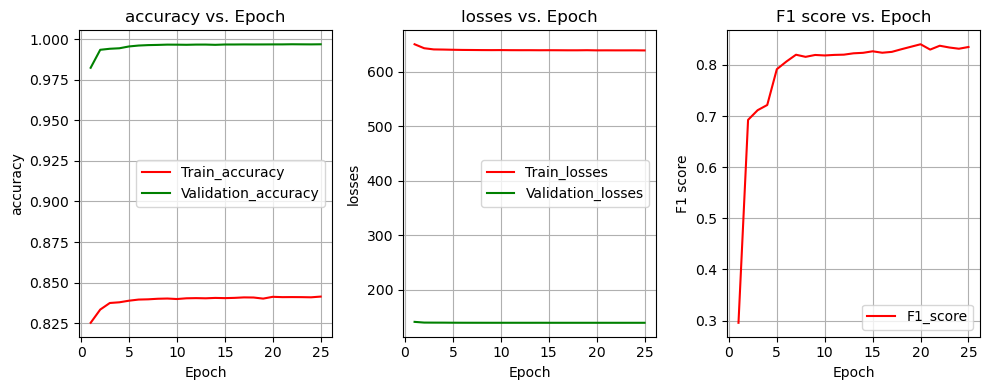

In [75]:
# # OPTIMAL ?
# # max_sequence_length = 20
batch_size = 32
hidden_dim = 512

max_sentence_len = [max(count_of_sentence_lengths[i]) for i in range(3)]

max_training_seq_len = max_sentence_len[2]
max_test_seq_len = max_sentence_len[2] # Full test data to validate on.
train_data_loader, validation_data_loader, train_sentence_len, validation_sentence_len = get_training_data(batch_size, max_training_seq_len)
test_data_loader, test_sentence_len = get_test_data(batch_size, max_test_seq_len)

# Initialize EarlyStopper and model
early_stopper = EarlyStopper(patience=5)
device = get_device()
epoch = 50
# e_weights = 10
# torch.tensor([e_weights, e_weights, e_weights, e_weights, e_weights, e_weights, e_weights, -10])
model = get_model(embedding_dim, hidden_dim, num_labels, pretrained_embeddings)

# Train the model
train_accuracies, validation_accuracies, train_losses, validation_losses, f1_score_arr, time_taken = train_model(model, train_data_loader, 
    validation_data_loader, validation_sentence_len, device=device, epochs=epoch, max_sequence_length=max_training_seq_len, early_stopper=early_stopper, debug=True)

# Obtain the F1_score and accuracy of the model using test set
test_accuracy, f1_score, y_true_tags, y_pred_tags = test_model(model, test_data_loader, test_sentence_len, device, max_sequence_length=max_test_seq_len)

plot_findings(len(train_accuracies), [[train_accuracies, validation_accuracies], [train_losses, validation_losses], [f1_score_arr]], "Epoch", isoptimal=True)

In [ ]:
def save_model(model, name_="NERModel.pth"):
    torch.save(model.state_dict(), name_)
    return True

def load_model(model, name_="NERModel.pth"):
    loaded_model.load_state_dict(torch.load('model.pth'))
    return True

In [76]:
save_model(model)

True

$ GPU Activated $


 48%|███████████████████████████████████████▎                                          | 24/50 [00:28<00:30,  1.19s/it]

Early stopping at epoch (25) due to no improvement in f1 score.
Time taken for the model to run finish: 28.47 seconds


Time taken to run finish: 0.41 seconds
F1 score: 0.7065, Test Accuracy: 2.4670


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:33<00:15,  2.17s/it]

Early stopping at epoch (44) due to no improvement in f1 score.
Time taken for the model to run finish: 93.26 seconds


Time taken to run finish: 0.37 seconds
F1 score: 0.7595, Test Accuracy: 2.4699


 66%|██████████████████████████████████████████████████████                            | 33/50 [01:23<00:42,  2.52s/it]

Early stopping at epoch (34) due to no improvement in f1 score.
Time taken for the model to run finish: 83.10 seconds


Time taken to run finish: 0.38 seconds
F1 score: 0.7089, Test Accuracy: 2.4671


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [03:36<00:35,  5.04s/it]

Early stopping at epoch (44) due to no improvement in f1 score.
Time taken for the model to run finish: 216.78 seconds


Time taken to run finish: 0.42 seconds
F1 score: 0.7594, Test Accuracy: 2.4697


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [03:29<00:34,  4.87s/it]


Early stopping at epoch (44) due to no improvement in f1 score.
Time taken for the model to run finish: 209.35 seconds
Time taken to run finish: 0.37 seconds
F1 score: 0.7611, Test Accuracy: 2.4698


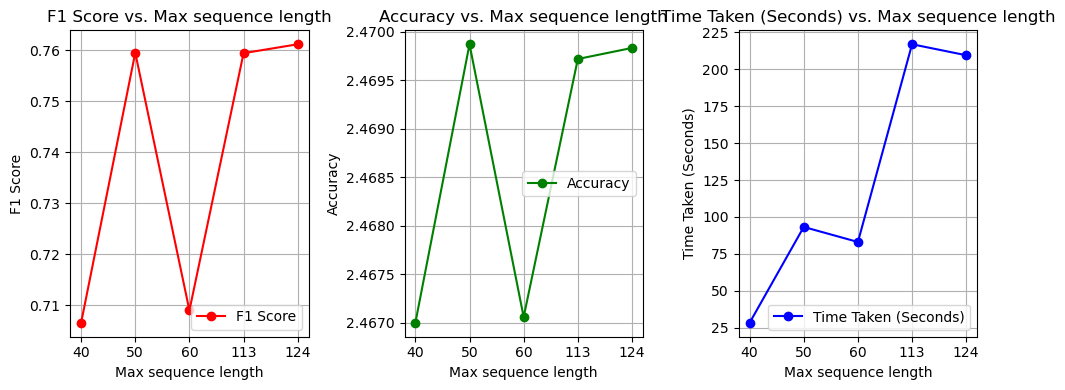

Best f1_score for Max sequence length: 124, 0.7611272056887015


In [69]:
hidden_dim = 128
device = get_device()
epoch = 50

max_test_seq_len = max_sentence_len[2]
test_data_loader, test_sentence_len = get_test_data(batch_size, max_test_seq_len)

F1_s, acc, tt = [], [], []
max_sequence_length = [40,50,60,113,124]
for msl in max_sequence_length:
    train_data_loader, validation_data_loader, train_sentence_len, validation_sentence_len = get_training_data(batch_size, msl)
    model = get_model(embedding_dim, hidden_dim, num_labels, pretrained_embeddings)
    early_stopper = EarlyStopper(patience=5)
    _,_,_,_, f1_score_arr, time_taken = train_model(model, train_data_loader, validation_data_loader, validation_sentence_len, device=device, epochs=epoch, max_sequence_length=msl, early_stopper=early_stopper, debug=False)
    test_accuracy, f1_score, _,_ = test_model(model, test_data_loader, test_sentence_len, device)
    F1_s.append(f1_score)
    acc.append(test_accuracy)
    tt.append(time_taken)
    
plot_findings(max_sequence_length, [F1_s,acc,tt], "Max sequence length")
print(f"Best f1_score for Max sequence length: {max_sequence_length[F1_s.index(max(F1_s))]}, {max(F1_s)}")

$ GPU Activated $


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [02:13<00:42,  3.52s/it]

Early stopping at epoch (39) due to no improvement in f1 score.
Time taken for the model to run finish: 133.89 seconds


Time taken to run finish: 0.31 seconds
F1 score: 0.7666, Test Accuracy: 2.4699


 48%|███████████████████████████████████████▎                                          | 24/50 [01:14<01:21,  3.12s/it]

Early stopping at epoch (25) due to no improvement in f1 score.
Time taken for the model to run finish: 74.91 seconds


Time taken to run finish: 0.25 seconds
F1 score: 0.7578, Test Accuracy: 2.4698


 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:31<00:51,  2.85s/it]

Early stopping at epoch (33) due to no improvement in f1 score.
Time taken for the model to run finish: 91.20 seconds


Time taken to run finish: 0.27 seconds
F1 score: 0.7650, Test Accuracy: 2.4698


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:56<00:25,  2.83s/it]

Early stopping at epoch (42) due to no improvement in f1 score.
Time taken for the model to run finish: 116.09 seconds


Time taken to run finish: 0.25 seconds
F1 score: 0.7069, Test Accuracy: 2.4671


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:12<00:00,  2.64s/it]


Time taken for the model to run finish: 132.24 seconds
Time taken to run finish: 0.28 seconds
F1 score: 0.6957, Test Accuracy: 2.4664


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [05:18<00:00,  6.36s/it]


Time taken for the model to run finish: 318.03 seconds
Time taken to run finish: 0.29 seconds
F1 score: 0.3819, Test Accuracy: 2.4449


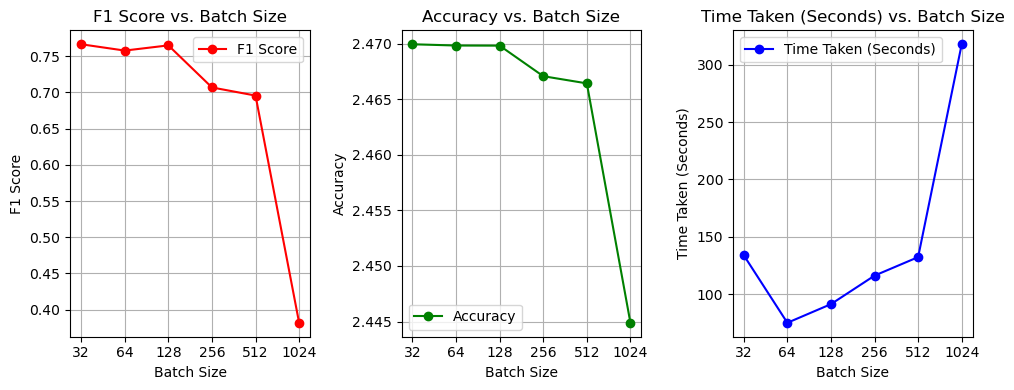

Best f1_score for Batch Size: 32, 0.7665744035850798


In [73]:
hidden_dim = 128
device = get_device()
epoch = 50
max_sequence_length = 124

max_test_seq_len = max_sentence_len[2] # Full test data to validate on.

F1_s, acc, tt = [], [], []
batch_size = [32,64,128,256,512,1024]
for BS in batch_size:
    train_data_loader, validation_data_loader, train_sentence_len, validation_sentence_len = get_training_data(BS, max_sequence_length)
    test_data_loader, test_sentence_len = get_test_data(BS, max_test_seq_len)
    model = get_model(embedding_dim, hidden_dim, num_labels, pretrained_embeddings)
    early_stopper = EarlyStopper(patience=5)
    
    _,_,_,_, f1_score_arr, time_taken = train_model(model, train_data_loader, validation_data_loader, validation_sentence_len, device=device, epochs=epoch, max_sequence_length=msl, early_stopper=early_stopper, debug=False)
    test_accuracy, f1_score, _,_ = test_model(model, test_data_loader, test_sentence_len, device)
    F1_s.append(f1_score)
    acc.append(test_accuracy)
    tt.append(time_taken)

plot_findings(batch_size, [F1_s,acc,tt], "Batch Size")
print(f"Best f1_score for Batch Size: {batch_size[F1_s.index(max(F1_s))]}, {max(F1_s)}")

$ GPU Activated $


 10%|████████▎                                                                          | 5/50 [00:09<01:24,  1.87s/it]

Early stopping at epoch (6) due to no improvement in f1 score.
Time taken for the model to run finish: 9.36 seconds


Time taken to run finish: 0.24 seconds
F1 score: 0.0000, Test Accuracy: 2.4360


 12%|█████████▉                                                                         | 6/50 [00:11<01:22,  1.87s/it]

Early stopping at epoch (7) due to no improvement in f1 score.
Time taken for the model to run finish: 11.25 seconds


Time taken to run finish: 0.25 seconds
F1 score: 0.0000, Test Accuracy: 2.4360


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:40<00:00,  2.01s/it]


Time taken for the model to run finish: 100.63 seconds
Time taken to run finish: 0.26 seconds
F1 score: 0.1804, Test Accuracy: 2.4398


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [05:24<00:00,  6.49s/it]


Time taken for the model to run finish: 324.39 seconds
Time taken to run finish: 0.30 seconds
F1 score: 0.4415, Test Accuracy: 2.4462


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:28<00:00,  2.96s/it]


Time taken for the model to run finish: 148.12 seconds
Time taken to run finish: 0.44 seconds
F1 score: 0.6417, Test Accuracy: 2.4610


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [24:55<00:00, 29.91s/it]


Time taken for the model to run finish: 1495.50 seconds
Time taken to run finish: 0.73 seconds
F1 score: 0.7110, Test Accuracy: 2.4667


100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [1:04:50<00:00, 77.81s/it]


Time taken for the model to run finish: 3890.67 seconds
Time taken to run finish: 1.82 seconds
F1 score: 0.7025, Test Accuracy: 2.4669


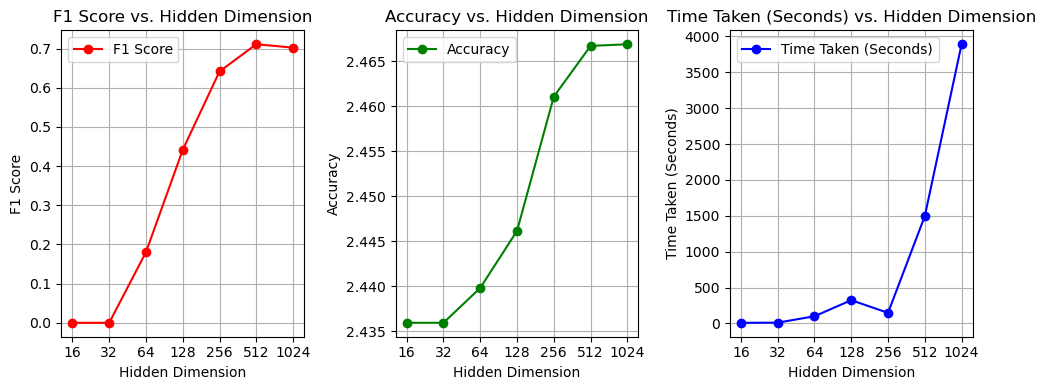

Best f1_score for Hidden Dim: 512, 0.7110276361685002


In [74]:
device = get_device()
epoch = 50
max_sequence_length = 124
max_test_seq_len = max_sentence_len[2]
batch_size = 32
test_data_loader, test_sentence_len = get_test_data(batch_size, max_test_seq_len)

hidden_dim = [16,32,64,128,256,512,1024] # Change to see if there are any improvements
F1_s, acc, tt = [], [], []
for hd in hidden_dim:
    model = get_model(embedding_dim, hd, num_labels, pretrained_embeddings)
    early_stopper = EarlyStopper(patience=5)
    # Train the model
    _,_,_,_, f1_score_arr, time_taken = train_model(model, train_data_loader, validation_data_loader, validation_sentence_len, device=device, epochs=epoch, max_sequence_length=max_sequence_length, early_stopper=early_stopper, debug=False)
    test_accuracy, f1_score, _,_ = test_model(model, test_data_loader, test_sentence_len, device)
    F1_s.append(f1_score)
    acc.append(test_accuracy)
    tt.append(time_taken)

plot_findings(hidden_dim, [F1_s,acc,tt], "Hidden Dimension")
print(f"Best f1_score for Hidden Dim: {hidden_dim[F1_s.index(max(F1_s))]}, {max(F1_s)}")